### Nest Asyncio

In [1]:
import nest_asyncio

nest_asyncio.apply()

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter Your OpenAI API Key: ")

In [ ]:
!mkdir data

In [3]:
!curl https://arxiv.org/html/2412.05579v2/ -o data/llms_as_jugdes.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  805k  100  805k    0     0  1825k      0 --:--:-- --:--:-- --:--:-- 1826k


In [6]:
!curl https://arxiv.org/html/2406.00936v1/ -o data/useful_llm_evaluation.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  255k  100  255k    0     0   196k      0  0:00:01  0:00:01 --:--:--  196k


In [7]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import BSHTMLLoader

path = "data/"
text_loader = DirectoryLoader(path, glob="*.html", loader_cls=BSHTMLLoader)

Next, we'll set up a classic naive chunking strategy as we only care that the documents get parsed into chunks that we can generate synthetic questions about.

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 700,
    chunk_overlap  = 50,
    length_function = len
)

In [9]:
training_documents = text_splitter.split_documents(text_loader.load())

In [10]:
len(training_documents)

767

Next, we're going to associate each of our chunks with a unique identifier.

In [11]:
import uuid

id_set = set()

for document in training_documents:
  id = str(uuid.uuid4())
  while id in id_set:
    id = uuid.uuid4()
  id_set.add(id)
  document.metadata["id"] = id

Next, we'll simply use naive Python slicing to create a training, test, and validation set to prepare our data for the next step.

In [20]:
training_split_documents = training_documents[:len(training_documents) - 100]
val_split_documents = training_documents[len(training_documents) - 100:767-50]
test_split_documents = training_documents[767-50:]

In [21]:
from langchain_openai import ChatOpenAI

qa_chat_model = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0
)

We'll create a simple Question Generation prompt to query `gpt-4o-mini` to generate Questions for each retrieved context.

In [22]:
from langchain_core.prompts import ChatPromptTemplate

qa_prompt = """\
Given the following context, you must generate questions based on only the provided context.

You are to generate {n_questions} questions which should be provided in the following format:

1. QUESTION #1
2. QUESTION #2
...

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

We'll create a simple chain to query the LLM!

In [23]:
question_generation_chain = qa_prompt_template | qa_chat_model

In [24]:
import tqdm
import asyncio

"""
Sample Usage of TQDM:

for i in tqdm.tqdm(range(10)):
  time.sleep(1)
"""

async def create_questions(documents, n_questions):

    questions = {}
    relevant_docs = {}

    for doc in tqdm.tqdm(documents, desc="Generating questions"):
        # Prepare the input for the chain
        input_context = doc.page_content
        doc_id = doc.metadata["id"]

        # Call the question generation chain
        response = await question_generation_chain.ainvoke({"context": input_context, "n_questions": n_questions})

        # Extract questions
        generated_questions = response.content.split("\n")
        generated_questions = [q.strip() for q in generated_questions if q.strip()]

        # Some outputs might be numbered like "1. What is ...?", so clean numbering
        cleaned_questions = []
        for q in generated_questions:
            if q[0].isdigit() and q[1] == '.':
                cleaned_questions.append(q[2:].strip())
            elif q[0].isdigit() and q[1] == ' ':
                cleaned_questions.append(q[1:].strip())
            else:
                cleaned_questions.append(q)

        # Now save each question
        for q in cleaned_questions:
            question_id = str(uuid.uuid4())
            questions[question_id] = q
            relevant_docs[question_id] = [doc_id]

    return questions, relevant_docs

### REMOVE `await` IF NOT USING ASYNC (HINT: Use `async`)

In [25]:
training_questions, training_relevant_contexts = await create_questions(training_split_documents, 2)

Generating questions: 100%|██████████| 667/667 [13:48<00:00,  1.24s/it]


We'll use the function to generate training, validation, and test data.

In [26]:
val_questions, val_relevant_contexts = await create_questions(val_split_documents, 2)

Generating questions: 100%|██████████| 50/50 [01:15<00:00,  1.50s/it]


In [27]:
test_questions, test_relevant_contexts = await create_questions(test_split_documents, 2)

Generating questions: 100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


In [28]:
import json

training_corpus = {train_item.metadata["id"] : train_item.page_content for train_item in training_split_documents}

train_dataset = {
    "questions" : training_questions,
    "relevant_contexts" : training_relevant_contexts,
    "corpus" : training_corpus
}

with open("training_dataset_evaluation_assistant.jsonl", "w") as f:
  json.dump(train_dataset, f)

In [29]:
val_corpus = {val_item.metadata["id"] : val_item.page_content for val_item in val_split_documents}

val_dataset = {
    "questions" : val_questions,
    "relevant_contexts" : val_relevant_contexts,
    "corpus" : val_corpus
}

with open("val_dataset_evaluation_assistant.jsonl", "w") as f:
  json.dump(val_dataset, f)

In [30]:
train_corpus = {test_item.metadata["id"] : test_item.page_content for test_item in test_split_documents}

test_dataset = {
    "questions" : test_questions,
    "relevant_contexts" : test_relevant_contexts,
    "corpus" : train_corpus
}

with open("test_dataset_evaluation_assistant.jsonl", "w") as f:
  json.dump(test_dataset, f)

In [31]:
from sentence_transformers import SentenceTransformer

model_id = "Snowflake/snowflake-arctic-embed-l"
model = SentenceTransformer(model_id)

We'll grab some necessary imports from `sentence_transformers` and `torch`.

> NOTE: PyTorch (`torch`) is a popular machine learning library - while we don't go very deep into PyTorch it's an incredibly powerful and interesting library! Please read more about it [here](https://pytorch.org/tutorials/beginner/basics/intro.html)!

In [32]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

We're using a toy batch size here to reflect the limited number of examples we have.

> NOTE: It is typical to use a much larger batch size (~64+), hardware permitting.

In [33]:
BATCH_SIZE = 10

Let's move our dataset into the expected format for training.

In [34]:
corpus = train_dataset['corpus']
queries = train_dataset['questions']
relevant_docs = train_dataset['relevant_contexts']

examples = []
for query_id, query in queries.items():
    doc_id = relevant_docs[query_id][0]
    text = corpus[doc_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

Now we can create a `torch` `DataLoader`!

In [35]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

In [36]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

matryoshka_dimensions = [768, 512, 256, 128, 64]
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

In [37]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

We'll train this model for 5 epochs, though you could increase this number if we had a significant amount more data.

In [38]:
EPOCHS = 10

In [39]:
import wandb
wandb.init(mode="disabled")

> NOTE: You may not see direct improvement during the training cycles - this is absolutely expected. We will verify performance later in the notebook.

In [40]:
warmup_steps = int(len(loader) * EPOCHS * 0.1)

model.fit(
    train_objectives=[(loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='finetuned_arctic_ft',
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/home/michelle/PROJECTS/code/evaluation_assistant/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [33]:
hf_username = "chelleboyer"

In [ ]:
import uuid

model.push_to_hub(f"{hf_username}/legal-ft-{uuid.uuid4()}")

## Task 5: Evaluating our Retriever

Now that we have fine-tuned our retriever - let's see if it's worthwhile!

We'll start with some basic imports.

In [35]:
import pandas as pd

from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

Now we'll define a function that will help us evaluate our retrieval process.

> NOTE: We're assuming 1 correct document in a "hit".

In [36]:
def evaluate_openai(
    dataset,
    embed_model,
    top_k=5,
    verbose=False,
):
  corpus = dataset['corpus']
  questions = dataset['questions']
  relevant_docs = dataset['relevant_contexts']
  documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]
  vectorstore = FAISS.from_documents(documents, embed_model)

  retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

  eval_results = []
  for id, question in tqdm.tqdm(questions.items()):
    retrieved_nodes = retriever.invoke(question)
    retrieved_ids = [node.metadata["id"] for node in retrieved_nodes]
    expected_id = relevant_docs[id][0]
    is_hit = expected_id in retrieved_ids
    eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

  return eval_results

All that's left to do is evaluate, we'll evaluate our model against:

1. OpenAI's closed source `text-embedding-3-small`
2. The base non-fine-tuned version of `Snowflake/snowflake-arctic-embed-l`.

Let's see how it stacks up!

### `text-embedding-3-small`

In [ ]:
te3_openai = OpenAIEmbeddings(model="text-embedding-3-small")
te3_results = evaluate_openai(test_dataset, te3_openai)

In [41]:
te3_results_df = pd.DataFrame(te3_results)

In [ ]:
te3_hit_rate = te3_results_df["is_hit"].mean()
te3_hit_rate

### `Snowflake/snowflake-arctic-embed-l` (base)

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

huggingface_embeddings = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-l")
arctic_embed_m_results = evaluate_openai(test_dataset, huggingface_embeddings)

In [44]:
arctic_embed_m_results_df = pd.DataFrame(arctic_embed_m_results)

In [ ]:
arctic_embed_m_hit_rate = arctic_embed_m_results_df["is_hit"].mean()
arctic_embed_m_hit_rate

### `Snowflake/snowflake-arctic-embed-l` (fine-tuned)

In [ ]:
finetune_embeddings = HuggingFaceEmbeddings(model_name="finetuned_arctic_ft")
finetune_results = evaluate_openai(test_dataset, finetune_embeddings)

In [47]:
finetune_results_df = pd.DataFrame(finetune_results)

In [ ]:
finetune_hit_rate = finetune_results_df["is_hit"].mean()
finetune_hit_rate

## Task 1: Vibe Checking the RAG Pipeline

We're going to use our RAG pipeline to vibe check on some common phrases now that we've modified it!

### Creating New Chunks

In order to try and evaluate our system more fairly, let's create new chunks that we will use to create our Vector Store.

In [49]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap  = 50,
    length_function = len
)

training_documents = text_splitter.split_documents(text_loader.load())

### Base Chain

We'll start by constructing our base chain, which will use the untrained retrieval model.

#### R - Retrieval

In [50]:
from langchain_community.vectorstores import FAISS

base_vectorstore = FAISS.from_documents(training_documents, huggingface_embeddings)
base_retriever = base_vectorstore.as_retriever(search_kwargs={"k": 6})

#### A - Augmented

In [51]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and a question, you must answer the question. If you do not know the answer, you must state that you do not know.

Context:
{context}

Question:
{question}

Answer:
"""

rag_prompt_template = ChatPromptTemplate.from_template(RAG_PROMPT)

#### G - Generation

In [52]:
rag_llm =  ChatOpenAI(
    model="gpt-4.1-nano",
    temperature=0
)

#### RAG - LCEL RAG Pipeline

In [53]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [ ]:
base_rag_chain.invoke({"question" : "Where can I eat pizza in Chicago?"})["response"]

In [ ]:
base_rag_chain.invoke({"question" : "Where can I go camping in the Midwest?"})["response"]

In [ ]:
base_rag_chain.invoke({"question" : "How long is the longest river in the Midwest?"})["response"]

In [ ]:
base_rag_chain.invoke({"question" : "Can I go hiking in Iowa"})["response"]

### Fine-tuned Embedding Model

Now let's rebuild our RAG chain with the Fine-tuned model - the only component we need to change is our `FAISS` vectorstore!

In [58]:
finetune_vectorstore = FAISS.from_documents(training_documents, finetune_embeddings)
finetune_retriever = finetune_vectorstore.as_retriever(search_kwargs={"k": 6})

In [59]:
finetune_rag_chain = (
    {"context": itemgetter("question") | finetune_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [ ]:
finetune_rag_chain.invoke({"question" : "What is an Agent?"})["response"]

In [ ]:
finetune_rag_chain.invoke({"question" : "Who has produced better models than GPT-3?"})["response"]

In [ ]:
finetune_rag_chain.invoke({"question" : "What is the laziest time of the year for AI?"})["response"]

In [ ]:
finetune_rag_chain.invoke({"question" : "What is the largest model that Simon has run on his phone?"})["response"]

#### ❓Question #2:

Which LCEL RAG Chain do you think answered the questions better, and why?

The fine tuned chain answered better and was able to answer all the questions.

## Task 2: RAGAS Evaluation

It's great to have some idea of how our system is doing based on vibe-checks, but let's use RAGAS to provide more insight info. on how things are improving!

> NOTE: Please recreate *exactly* the RAGAS process we used to evaluate RAG, baselining with the default retriever, and then comparing the new retriever. The includes the Synthetic Data Generation steps.

In [ ]:
#!pip install -qU ragas datasets rapidfuzz

In [71]:
#from langchain_community.document_loaders import DirectoryLoader
#from langchain_community.document_loaders import BSHTMLLoader

#path = "data/"
#text_loader = DirectoryLoader(path, glob="*.html", loader_cls=BSHTMLLoader)

docs = text_loader.load()

I need to refactor the original code in functon calls so i don't have to duplicate code here.

In [77]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from ragas.testset import TestsetGenerator
from ragas import evaluate, RunConfig
from ragas import EvaluationDataset
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas.llms import LangchainLLMWrapper

def generate_questions(gen_model, embed_model, n_questions=10):

  generator_llm = LangchainLLMWrapper(gen_model)
  generator_embeddings = LangchainEmbeddingsWrapper(embed_model)

  generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
  dataset = generator.generate_with_langchain_docs(docs, testset_size=n_questions)

  return dataset

def run_response_chain(dataset, chain):
  from tqdm import tqdm

  for test_row in dataset:
    response = chain.invoke({"question" : test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"]
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

  return dataset

def run_evaluation(dataset, llm):
  evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())
  evaluator_llm = LangchainLLMWrapper(llm)

  custom_run_config = RunConfig(timeout=360)

  result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
  )

  return result

This is where I can run the before and after on each retriever.

#### Baseline Evaluation

In [ ]:
base_test_dataset = generate_questions(rag_llm,huggingface_embeddings)

In [79]:
base_eval_dataset = run_response_chain(base_test_dataset,base_rag_chain)

In [ ]:
base_eval_result = run_evaluation(base_eval_dataset,rag_llm)

In [ ]:
import os
from getpass import getpass
os.environ["RAGAS_APP_TOKEN"] = getpass("Please enter your RAGAS Token!")

In [ ]:
base_test_dataset.upload()

In [ ]:
base_eval_result

####Fine-tuned Evaluation

In [ ]:
finetune_test_dataset = generate_questions(rag_llm,finetune_embeddings)

In [ ]:
finetune_test_dataset.upload()

In [93]:
finetune_eval_dataset = run_response_chain(finetune_test_dataset,finetune_rag_chain)

In [ ]:
finetune_eval_result = run_evaluation(finetune_eval_dataset,rag_llm)

In [ ]:
finetune_eval_result

#### Interpretation
| **Metric**                   | **Interpretation**                                                                 |
|-----------------------------|-------------------------------------------------------------------------------------|
| **Context Recall**          | 🔻 Slight drop — the model is pulling in *slightly* less of the context. |
| **Faithfulness**            | 🚀 Major gain — outputs are now significantly more faithful to the source. |
| **Factual Correctness**     | ✅ Good bump — answers are getting more accurate. Probably a direct result of better grounding. |
| **Answer Relevancy**        | 🎯 A solid improvement — responses are better aligned with the query intent.          |
| **Context Entity Recall**   | 🧠 More named entities are being captured from context — now recognizing more of the “who” and “what.” |
| **Noise Sensitivity (Relevant)** | 🧹 Big drop — the model is much less distracted by irrelevant noise.|



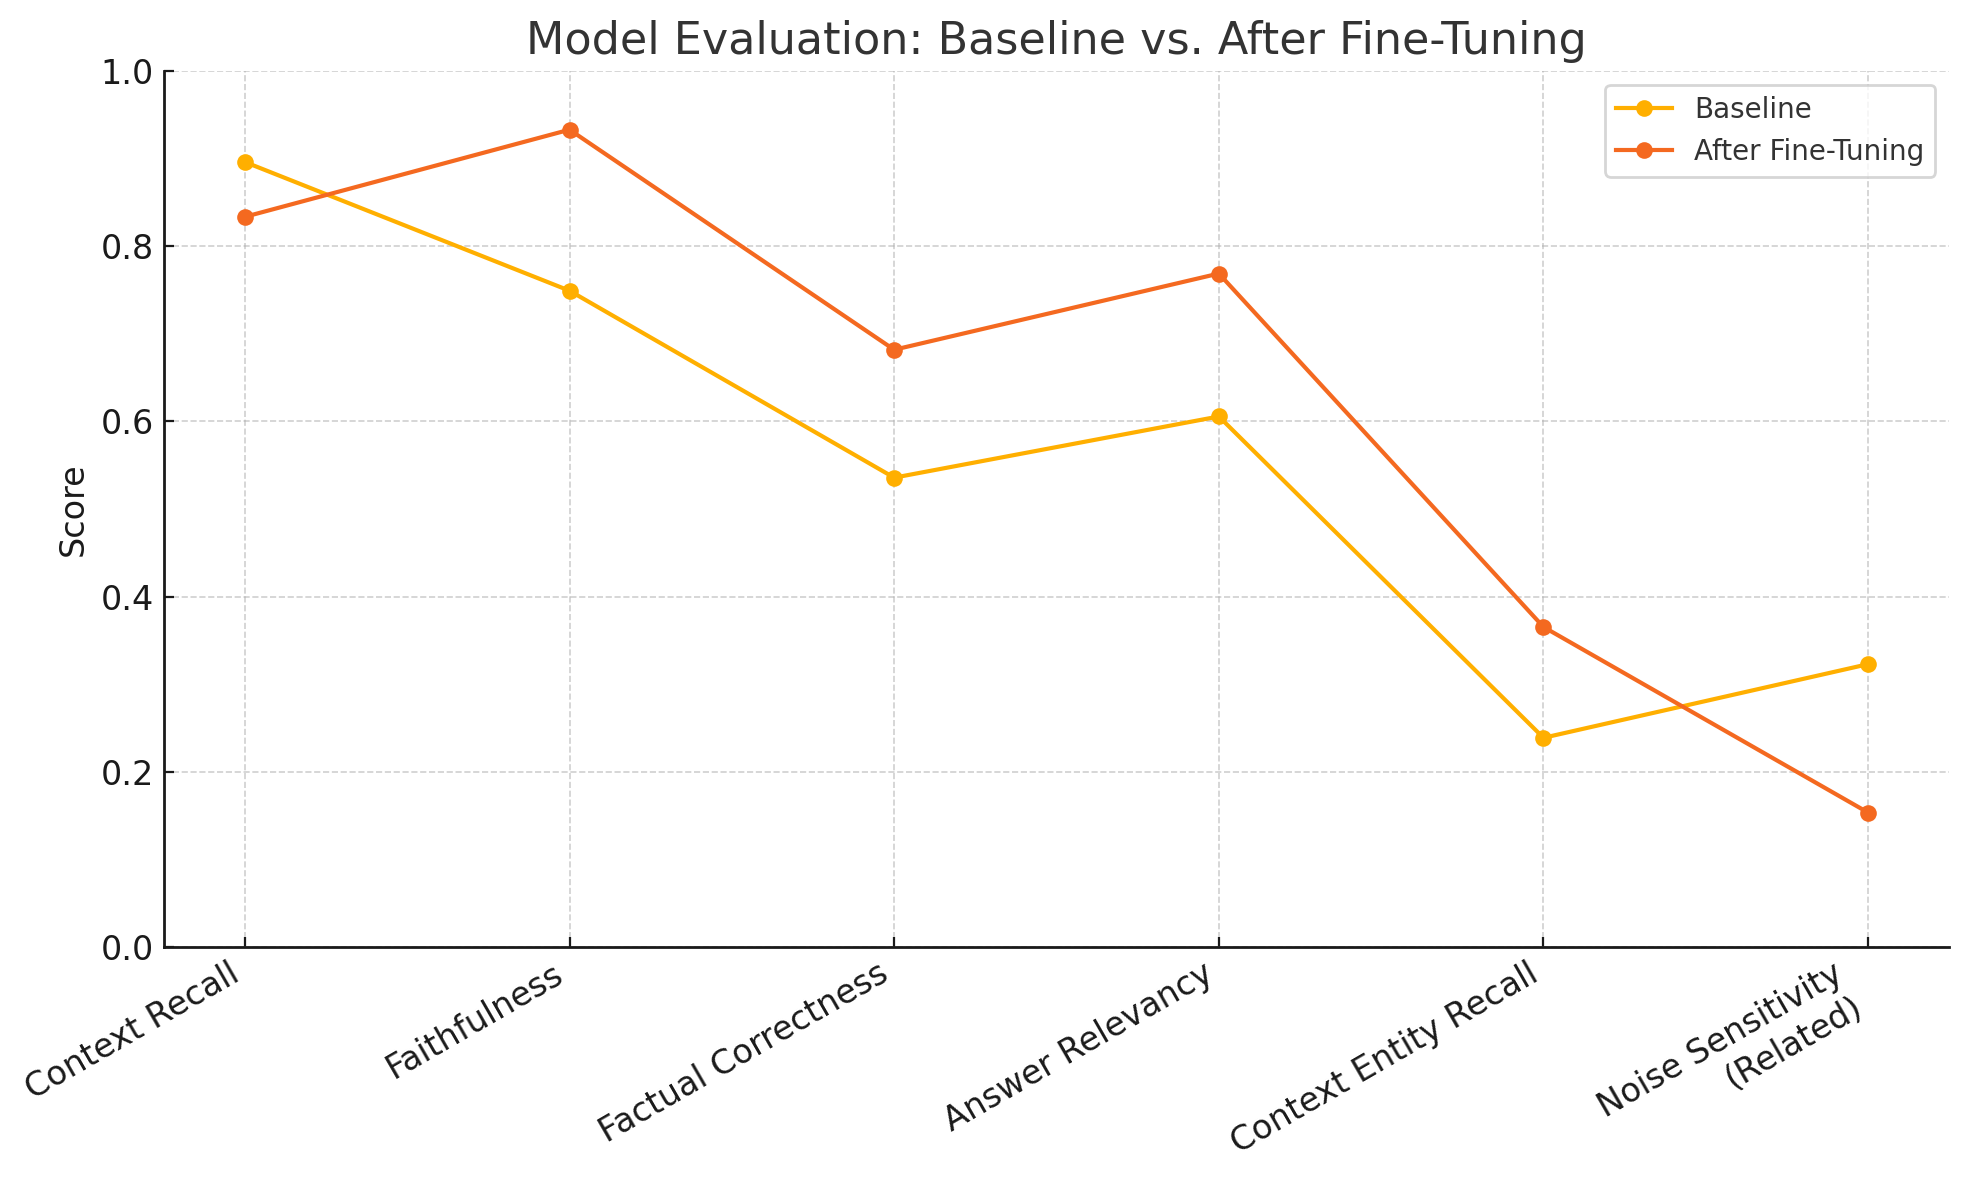